# Determine Displayed Charuco Chart Dimensions
- **Prepare** a stereo camera system (e.g. two Basler acA1300-200um)
    - The baseline between the two cameras should match about the distance of the human eyes.
- **Display** a Charuco board on a screen or print it out.
    - Make sure the displayed dimensions of the checker-board match the proto settings for the calibration code.
- **Collect** synchronized images with the two cameras

**Goal:** Determine the actual size of a Charuco board using a stereo camera setup and its intrinsic and extrinsic parameters.

This method leverages the known geometry of the stereo camera setup and the identifiable markers on the Charuco board to extract real-world measurements without prior knowledge of the board's dimensions.

**Notes:**
- **Calibration:** The intrinsic and extrinsic parameters of the stereo camera system can be determined following [this](https://docs.google.com/document/d/1nUxG2-sRL8YM3wsnlqll48YL8POIgJ6VQxjQ2N5RWPc/edit?usp=sharing) document.
- **Accuracy Dependence:** The accuracy of the measurements depends on the precision of the camera calibration and the quality of the marker detection.
- **Assumption:** This method assumes that the baseline (distance between the stereo cameras) is known and accurately reflected in the extrinsic parameters.
- **Error Handling:** The calibration needs to accurately correct for lens distortions - ideally radial and tangential distortion correction.

**References:**
- OpenCV Camera Calibration and 3D Reconstruction: [OpenCV Documentation](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)
- Converting Euler Angles to Rotation Matrix: [Scipy Spacial Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html)
- Understanding Distortion Coefficients: [Camera Calibration With OpenCV](https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html)
- Camera Matrix: [Computer Vision](https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf)
- OpenCV: [Detection of ChArUco boards](https://docs.opencv.org/4.x/df/d4a/tutorial_charuco_detection.html)
- OpenCV Documentation: [Aruco Marker Detection](https://docs.opencv.org/3.4/d9/d6a/group__aruco.html#ggac84398a9ed9dd01306592dd616c2c975a6eb1a3e9c94c7123d8b1904a57193f16)
- OpenCV: [Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html)
- Medium: [Using ChArUco boards in OpenCV](https://medium.com/@ed.twomey1/using-charuco-boards-in-opencv-237d8bc9e40d)
- Medium: [A Comprehensive Guide to Camera Calibration Using ChArUco Boards and OpenCV for Perspective Projection](https://medium.com/@nflorent7/a-comprehensive-guide-to-camera-calibration-using-charuco-boards-and-opencv-for-perspective-9a0fa71ada5f)
- Medium: [OpenCV Camera Calibration](https://medium.com/@amit25173/opencv-camera-calibration-03d19f0f52bc)
- Epipolar Geometry: [CS231A Course Notes 3](https://web.stanford.edu/class/cs231a/course_notes/03-epipolar-geometry.pdf)
- Epipolar Geometry and the Fundamental Matrix: [University of Oxford](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf)




**Note:** To have access to all required libraries, it might be necessary to execute the following from a terminal command-line:
1. Change into a work-environement (e.g. `hgd camera_calibration`)
2. `blaze run -c opt //experimental/users/bwilburn/starline:sandbox -- --logtostderr --port=8888`

In [ ]:
import os
import cv2
from cv2 import aruco
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import shutil
# from scipy.spatial.transform import Rotation
from google.colab.patches import cv2_imshow

In [ ]:
print("[INFO] OpenCV Version:", cv2.__version__)

[INFO] OpenCV Version: 4.10.0


## General Settings and Parameters

In [ ]:
# define names of each possible ArUco tag OpenCV supports
class ArucoDictConstant(int):
  def __new__(cls, name, value):
    obj = int.__new__(cls, value)
    obj.name = name
    return obj
  def __repr__(self):
    return self.name
  def __str__(self):
    return self.name

ARUCO_DICT_CHOICES = {
  "DICT_4X4_50": ArucoDictConstant("aruco.DICT_4X4_50", aruco.DICT_4X4_50),
  "DICT_4X4_100": ArucoDictConstant("aruco.DICT_4X4_100", aruco.DICT_4X4_100),
  "DICT_4X4_250": ArucoDictConstant("aruco.DICT_4X4_250", aruco.DICT_4X4_250),
  "DICT_4X4_1000": ArucoDictConstant("aruco.DICT_4X4_1000", aruco.DICT_4X4_1000),

  "DICT_5X5_50": ArucoDictConstant("aruco.DICT_5X5_50", aruco.DICT_5X5_50),
  "DICT_5X5_100": ArucoDictConstant("aruco.DICT_5X5_100", aruco.DICT_5X5_100),
  "DICT_5X5_250": ArucoDictConstant("aruco.DICT_5X5_250", aruco.DICT_5X5_250),
  "DICT_5X5_1000": ArucoDictConstant("aruco.DICT_5X5_1000", aruco.DICT_5X5_1000),

  "DICT_6X6_50": ArucoDictConstant("aruco.DICT_6X6_50", aruco.DICT_6X6_50),
  "DICT_6X6_100": ArucoDictConstant("aruco.DICT_6X6_100", aruco.DICT_6X6_100),
  "DICT_6X6_250": ArucoDictConstant("aruco.DICT_6X6_250", aruco.DICT_6X6_250),
  "DICT_6X6_1000": ArucoDictConstant("aruco.DICT_6X6_1000", aruco.DICT_6X6_1000),

  "DICT_7X7_50": ArucoDictConstant("aruco.DICT_7X7_50", aruco.DICT_7X7_50),
  "DICT_7X7_100": ArucoDictConstant("aruco.DICT_7X7_100", aruco.DICT_7X7_100),
  "DICT_7X7_250": ArucoDictConstant("aruco.DICT_7X7_250", aruco.DICT_7X7_250),
  "DICT_7X7_1000": ArucoDictConstant("aruco.DICT_7X7_1000", aruco.DICT_7X7_1000),

  "DICT_ARUCO_ORIGINAL": ArucoDictConstant("aruco.DICT_ARUCO_ORIGINAL", aruco.DICT_ARUCO_ORIGINAL),
  "DICT_APRILTAG_16h5": ArucoDictConstant("aruco.DICT_APRILTAG_16h5", aruco.DICT_APRILTAG_16h5),
  "DICT_APRILTAG_25h9": ArucoDictConstant("aruco.DICT_APRILTAG_25h9", aruco.DICT_APRILTAG_25h9),
  "DICT_APRILTAG_36h10": ArucoDictConstant("aruco.DICT_APRILTAG_36h10", aruco.DICT_APRILTAG_36h10),
  "DICT_APRILTAG_36h11": ArucoDictConstant("aruco.DICT_APRILTAG_36h11", aruco.DICT_APRILTAG_36h11),
}

In [ ]:
# """ Hack to detect the Charuco Marker Type """
# # Loop over the types of ArUco dictionaries
# corners_detected = 0
# marker_name = ""
# for (charuco_name, charuco_dict) in ARUCO_DICT_CHOICES.items():
#   # load the ArUCo dictionary, grab the ArUCo parameters, and
#   # attempt to detect the markers for the current dictionary
#   charuco_dict = aruco.getPredefinedDictionary(charuco_dict)
#   charucoParams = aruco.DetectorParameters()
#   detector = aruco.ArucoDetector(charuco_dict, charucoParams)
#   (corners, ids, rejected) = cv2.aruco.detectMarkers(
#     img_left, charuco_dict, parameters=charucoParams)
#   # if at least one ArUco marker was detected display the ArUco
#   # name to our terminal
#   if len(corners) > corners_detected:
#     corners_detected = len(corners)
#     marker_name = charuco_name
# print(f"[INFO] The detected charuco marker name is {marker_name}.")

In [ ]:
BOARD = "DICT_5X5_250"    #"DICT_5X5_250_station"    #"DICT_5X5_250"  #"DICT_6X6_250"
camera_names = ["tracker0","tracker1"]    # ["camera0", "camera1"]
CAL_VERSION = "16"
''' Path to the test images that are stored on Cloudtop '''
if BOARD == "DICT_6X6_250":
  IMG_LEFT_PATH  = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_6X6_250_small/" + camera_names[0]
  IMG_RIGHT_PATH = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_6X6_250_small/" + camera_names[1]
elif BOARD == "DICT_5X5_250_station":
  IMG_LEFT_PATH  = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_5X5_250_station/" + camera_names[0]
  IMG_RIGHT_PATH = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_5X5_250_station/" + camera_names[1]
else:
  IMG_LEFT_PATH  = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal_new1_5X5_260/tracker0"
  IMG_RIGHT_PATH = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal_new1_5X5_260/tracker1"
  # IMG_LEFT_PATH  = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_5X5_250_medium/" + camera_names[0]
  # IMG_RIGHT_PATH = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal" + CAL_VERSION + "_5X5_250_medium/" + camera_names[1]

''' Path to the calibration rio file that is stored on Cloudtop or
(if running a charuco calibration with this colab) the location and file where to save the calibration rio file.'''
CALIBRATION_RIO_FILE = "/usr/local/google/home/araschl/Projects/calibu_cal/calOutput_stereo_new_1/final_rig.rio"
# "/usr/local/google/home/araschl/Projects/calibu_cal/calOutput_stereo_" + CAL_VERSION + "/final_rig.rio"

''' Pick one sample for testing '''
PICK_ONLY_THIS = None    # 35    # None if pick all

''' If looking at the mirror of the chart, then the image needs to be mirrored
back so the marker-detection works '''
MIRROR_MODE = False   # True

''' Sample image numbers '''
SAMPLE_TO_DISPLAY_NUMBER = 0   #24 if PICK_ONLY_THIS is None else 0
# Set this to a number or to 'auto'.
# If this is set to 'auto', then the first image that shows a full row and a full column will be used for the display at the bottom
FINAL_OVERLAY_IMAGE = SAMPLE_TO_DISPLAY_NUMBER   #"auto"

''' Calibrate the cameras using a CharUco board '''
RUN_CHARUCO_CALIBRATION = False   # True
CALIBRATION_IMAGES_PATH = "/usr/local/google/home/araschl/Projects/charuco_cal/pictures/camera_calibration"
CAL_LEFT_IMAGES = "images_camera0"
CAL_RIGHT_IMAGES = "images_camera1"

''' Reprojection error to determine if the calibration is correct '''
REPROJECTION_ERROR_LIMIT = 1    # For perfect calibration < 0.5, 0.5 - 1 for general purpos, but may need improvement for high-precision
CALIBRATION_IS_ACCURATE = True  # Flag to determine if the calibration used for calculation of ststistics is up-to-date

if BOARD == "DICT_6X6_250":
  ''' The ground truth width and height of the Charuco board '''
  ''' Measure these values with a ruler from one end of the chess-board pattern to the other. '''
  CHARUCO_GROUND_TRUTH_WIDTH = 0.414    # 0.997    # 0.412  # in meters
  CHARUCO_GROUND_TRUTH_HEIGHT = 0.233   # 0.561   # 0.232 # in meters

  ''' Collect parameters and dimensions of the Charuco board used for this size estimation'''
  # ------------------------------
  # PARAMETERS for the Charuco Chart:
  # Board dimensions: (h, w) = (56.1cm, 99.6cm)
  ARUCO_DICT = aruco.DICT_6X6_250     #ARUCO_DICT_CHOICES[marker_name]   # (see: https://docs.opencv.org/3.4/d9/d6a/group__aruco.html#ggac84398a9ed9dd01306592dd616c2c975a6eb1a3e9c94c7123d8b1904a57193f16)
  SQUARES_HORIZONTALLY = 14  # 5 # squares in X-direction
  SQUARES_VERTICALLY = 9     # 7  # squares in Y-direction
  SQUARE_LENGTH = 0.040   # 0.025  # 0.062   # 0.025  # 0.03 # Square length and width in meters
  MARKER_LENGTH = 0.030   # 0.013  # 0.032   # 0.013  # 0.015  # Square marker length and width in meters
  LENGTH_PX = 640   # total length of the page in pixels (only for the display here)
  MARGIN_PX = 20    # size of the margin in pixels (only for the diaplay here)
  MARKER_START_ID = 0    # Specify here the start marker ID value. The range of the markers is determined with the help of SQUARES_HORIZONTALLY and SQUARES_VERTICALLY
  # ------------------------------
else:
  ''' The ground truth width and height of the Charuco board '''
  ''' Measure these values with a ruler from one end of the chess-board pattern to the other. '''
  CHARUCO_GROUND_TRUTH_WIDTH = 0.56    # in meters
  CHARUCO_GROUND_TRUTH_HEIGHT = 0.36   # in meters

  ''' Collect parameters and dimensions of the Charuco board used for this size estimation'''
  # ------------------------------
  # PARAMETERS for the Charuco Chart:
  # Board dimensions: (h, w) = (56.1cm, 99.6cm)
  ARUCO_DICT = aruco.DICT_5X5_250     #ARUCO_DICT_CHOICES[marker_name]   # (see: https://docs.opencv.org/3.4/d9/d6a/group__aruco.html#ggac84398a9ed9dd01306592dd616c2c975a6eb1a3e9c94c7123d8b1904a57193f16)
  SQUARES_HORIZONTALLY = 14 # squares in X-direction
  SQUARES_VERTICALLY = 9    # squares in Y-direction
  SQUARE_LENGTH = 0.040     # Square length and width in meters
  MARKER_LENGTH = 0.030     # Square marker length and width in meters
  LENGTH_PX = 640   # total length of the page in pixels (only for the display here)
  MARGIN_PX = 20    # size of the margin in pixels (only for the diaplay here)
  MARKER_START_ID = 0    # Specify here the start marker ID value. The range of the markers is determined with the help of SQUARES_HORIZONTALLY and SQUARES_VERTICALLY
  # ------------------------------

In [ ]:
# ---- Reorganize the files ----
# Assuming that the files of the left and the right camera are all in the same higher-level folder of IMG_LEFT_PATH
# --> reorganize the files, so that left camera images are in IMG_LEFT_PATH and right camera images are in IMG_RIGHT_PATH
REORGANIZE = True
if os.path.exists(IMG_LEFT_PATH) and os.path.exists(IMG_RIGHT_PATH):
  REORGANIZE = False
  print("[INFO] Not reorganizing!")
if REORGANIZE:
  # Create the target folder:
  os.makedirs(IMG_LEFT_PATH, exist_ok=True)
  os.makedirs(IMG_RIGHT_PATH, exist_ok=True)
  pictures_path0, cam0_folder = os.path.split(IMG_LEFT_PATH)
  pictures_path1, cam1_folder = os.path.split(IMG_RIGHT_PATH)
  if pictures_path0 != pictures_path1:
    raise ValueError("[ERROR] There seems to be an error in the paths for the left and the right camera!")
  pictures_path = pictures_path0
  print(f"[INFO] Pictures folder: {pictures_path} and the camera0 folder: {cam0_folder} and camera1 folder: {cam1_folder}")
  # Distribute the files into the two folders:
  for file in os.listdir(pictures_path):
    if file.endswith((".png", ".jpg")):
      if "tracker0" in file:
        shutil.move(os.path.join(pictures_path, file), os.path.join(IMG_LEFT_PATH, file))
      else:
        shutil.move(os.path.join(pictures_path, file), os.path.join(IMG_RIGHT_PATH, file))


[INFO] Not reorganizing!


## 0. Read the Images

In [ ]:
''' Collect the original images for the left and right cameras '''
try:
  image_left_files = [f for f in os.listdir(IMG_LEFT_PATH) if os.path.isfile(os.path.join(IMG_LEFT_PATH, f)) and f.endswith(".png")]
  image_left_paths = sorted([os.path.join(IMG_LEFT_PATH, f) for f in image_left_files])
  if PICK_ONLY_THIS is not None:
    image_left_paths = [image_left_paths[PICK_ONLY_THIS]]
  print(f"[INFO] Amount of images found for the left camera: {len(image_left_files)}")
  print(f"[INFO] Left Images: {image_left_files}")
  print(f"[INFO] Left Image paths: {image_left_paths}")

  image_right_files = [f for f in os.listdir(IMG_RIGHT_PATH) if os.path.isfile(os.path.join(IMG_RIGHT_PATH, f)) and f.endswith(".png")]
  image_right_paths = sorted([os.path.join(IMG_RIGHT_PATH, f) for f in image_right_files])
  if PICK_ONLY_THIS is not None:
    image_right_paths = [image_right_paths[PICK_ONLY_THIS]]
  print(f"\n[INFO] Amount of images found for the right camera: {len(image_right_files)}")
  print(f"[INFO] Right Images: {image_right_files}")
  print(f"[INFO] Right Image paths: {image_right_paths}")
except Exception as e:
  print(f"An error occurred: {e}")
  print(f"Error type: {type(e).__name__}")
  print("Probably the path to the images is not correct.")

[INFO] Amount of images found for the left camera: 1
[INFO] Left Images: ['tracker0_frame_0.png']
[INFO] Left Image paths: ['/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal_new1_5X5_260/tracker0/tracker0_frame_0.png']

[INFO] Amount of images found for the right camera: 1
[INFO] Right Images: ['tracker1_frame_0.png']
[INFO] Right Image paths: ['/usr/local/google/home/araschl/Projects/charuco_cal/pictures/cal_new1_5X5_260/tracker1/tracker1_frame_0.png']


In [ ]:
''' Pick test images for left and right cameras. These images need to be synchronized. '''
img_left = cv2.imread(image_left_paths[SAMPLE_TO_DISPLAY_NUMBER])
img_right = cv2.imread(image_right_paths[SAMPLE_TO_DISPLAY_NUMBER])

image_width = img_left.shape[1]
image_height = img_left.shape[0]

print(f"[INFO] Left Images: {np.shape(img_left)}")
print(f"[INFO] Right Images: {np.shape(img_right)}")

[INFO] Left Images: (500, 960, 3)
[INFO] Right Images: (500, 960, 3)


## 1. Define the used CharUco board

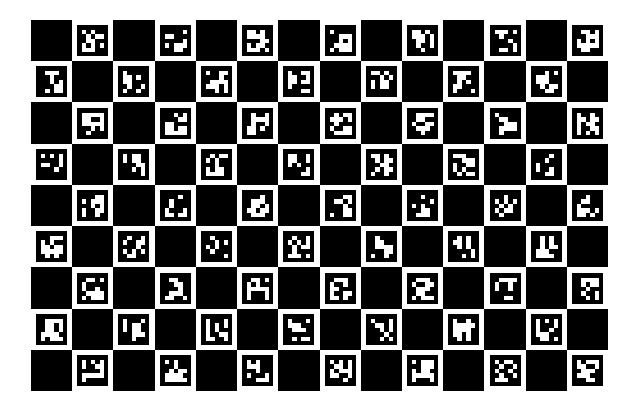

In [ ]:
def sample_charuo_board():
  startid = MARKER_START_ID   # Start ID for the CharUco board
  num_ids = (SQUARES_HORIZONTALLY // 2) * SQUARES_VERTICALLY    # This is the range of ids on the used CharUco board
  ids = np.arange(startid, startid + num_ids, 1)

  dictionary = aruco.getPredefinedDictionary(ARUCO_DICT)
  board = aruco.CharucoBoard((SQUARES_HORIZONTALLY,SQUARES_VERTICALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary, ids=ids)
  size_ratio = SQUARES_VERTICALLY /SQUARES_HORIZONTALLY
  img = aruco.CharucoBoard.generateImage(board, (LENGTH_PX, int(LENGTH_PX*size_ratio)), marginSize=MARGIN_PX)
  cv2_imshow(img)
  return img

image_new = sample_charuo_board()

## 2. Prepare the CharUco Detector
- **Capture Images:** Using the stereo camera setup, capture images of the Charuco board simultaneously from both cameras.
- **Marker Detection:** Utilizing OpenCV's `aruco` module to detect the Charuco markers in both left and right images.

In [ ]:
''' Define Charuco board parameters '''
startid = MARKER_START_ID     # Start ID for the CharUco board
num_ids = (SQUARES_HORIZONTALLY // 2) * SQUARES_VERTICALLY    # This is the amount of id on the used CharUco board
ids = np.arange(startid, startid + num_ids, 1)

charuco_dict = aruco.getPredefinedDictionary(ARUCO_DICT)
charuco_board = aruco.CharucoBoard((SQUARES_HORIZONTALLY,SQUARES_VERTICALLY), SQUARE_LENGTH, MARKER_LENGTH, charuco_dict, ids=ids)
params = aruco.DetectorParameters()
detector = aruco.ArucoDetector(charuco_dict, params)

## 3. (Optional) Calibrate using CharUco
The *.rio* file given in `CALIBRATION_RIO_FILE` will be overwritten with new calibration data.

In [ ]:
# Run an intrinsic and extrinsic calibration for the stereo camera system

# # Function to generate object points for the Charuco board
# def generate_charuco_board_corners(board):
#   squaresX, squaresY = board.getChessboardSize()
#   print(f"squaresX: {squaresX}, squaresY: {squaresY}")
#   squareLength = board.getSquareLength()
#   print(f"squareLength: {squareLength}")
#   objp = []  # 3D points in the real-world space
#   for i in range(squaresY):
#     for j in range(squaresX):
#       objp.append([j * squareLength, i * squareLength, 0])  # Z = 0 for all points
#   return np.array(objp, dtype=np.float32)

# # Generate the object points (3D coordinates of corners in real world)
# object_points = generate_charuco_board_corners(charuco_board)

# # Lists to store detected corners and ids for both cameras
# all_corners_camera0 = []
# all_ids_camera0 = []
# all_corners_camera1 = []
# all_ids_camera1 = []
# image_size_camera0 = None
# image_size_camera1 = None

# # The paths to the calibration images are stored in `image_left_paths` for the left camera and
# # in `image_right_paths` for the right camera
# left_folder_path = os.path.join(CALIBRATION_IMAGES_PATH, CAL_LEFT_IMAGES)
# right_folder_path = os.path.join(CALIBRATION_IMAGES_PATH, CAL_RIGHT_IMAGES)
# image_left_paths = [f for f in os.listdir(left_folder_path) if f.endswith(".png")]
# image_right_paths = [f for f in os.listdir(right_folder_path) if f.endswith(".png")]
# image_left_paths = [os.path.join(left_folder_path, f) for f in image_left_paths]
# image_right_paths = [os.path.join(right_folder_path, f) for f in image_right_paths]

# # Prepare lists for object points and image points
# objpoints = []  # 3D points in real-world space
# image_points_camera0 = []  # 2D points for camera0
# image_points_camera1 = []  # 2D points for camera1

# # For all calibration CharUco image pairs
# for img0_path, img1_path in zip(image_left_paths, image_right_paths):
#   # print(f"Reading image {img0_path} and {img1_path}")
#   img0 = cv2.imread(img0_path)
#   img1 = cv2.imread(img1_path)

#   gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
#   gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#   # Detect ArUco markers in both images
#   charucodetector_left = cv2.aruco.CharucoDetector(charuco_board)
#   charuco_corners0, charuco_ids0, marker_corners_left, marker_ids_left = charucodetector_left.detectBoard(gray0)
#   charucodetector_right = cv2.aruco.CharucoDetector(charuco_board)
#   charuco_corners1, charuco_ids1, marker_corners_right, marker_ids_right = charucodetector_right.detectBoard(gray1)

#   if charuco_corners0 is not None and charuco_corners1 is not None:
#     objpoints.append(object_points)  # Same for both images (since the board is static)

#     image_points_camera0.append(charuco_corners0)
#     image_points_camera1.append(charuco_corners1)

#     if image_size_camera0 is None:
#       image_size_camera0 = gray0.shape[::-1]
#     if image_size_camera1 is None:
#       image_size_camera1 = gray1.shape[::-1]

# # Perform camera calibration for both cameras separately
# print(f"length of objpoints: {len(objpoints)}")
# if len(objpoints) > 0:
#   # Ensure the number of object points and image points match
#   if len(objpoints) == len(image_points_camera0) == len(image_points_camera1):
#     # Camera calibration for camera0
#     retval_camera0, camera_matrix0, dist_coeffs0, rvecs_camera0, tvecs_camera0 = cv2.calibrateCamera(
#         objectPoints=objpoints,
#         imagePoints=image_points_camera0,
#         imageSize=image_size_camera0,
#         cameraMatrix=None,
#         distCoeffs=None
#     )
#     # Camera calibration for camera1
#     retval_camera1, camera_matrix1, dist_coeffs1, rvecs_camera1, tvecs_camera1 = cv2.calibrateCamera(
#         objectPoints=objpoints,
#         imagePoints=image_points_camera1,
#         imageSize=image_size_camera1,
#         cameraMatrix=None,
#         distCoeffs=None
#     )

# ending

## 3. Detect Markers and Corners

In [ ]:
# For mirrored images flip the coordinates of detected corners and markers back:
def flip_corners_back(corners, flip_axis, image_width, image_height):
  if flip_axis == 1:  # Horizontal flip
    flipped_corners = [[(image_width - x, y)] for (x, y) in corners]
  elif flip_axis == 0:  # Vertical flip
    flipped_corners = [(x, image_height - y) for (x, y) in corners]
  elif flip_axis == -1:  # Both axes flip
    flipped_corners = [(image_width - x, image_height - y) for (x, y) in corners]
  else:
    flipped_corners = corners  # No flip, return original
  return np.array(flipped_corners, dtype=np.float32)

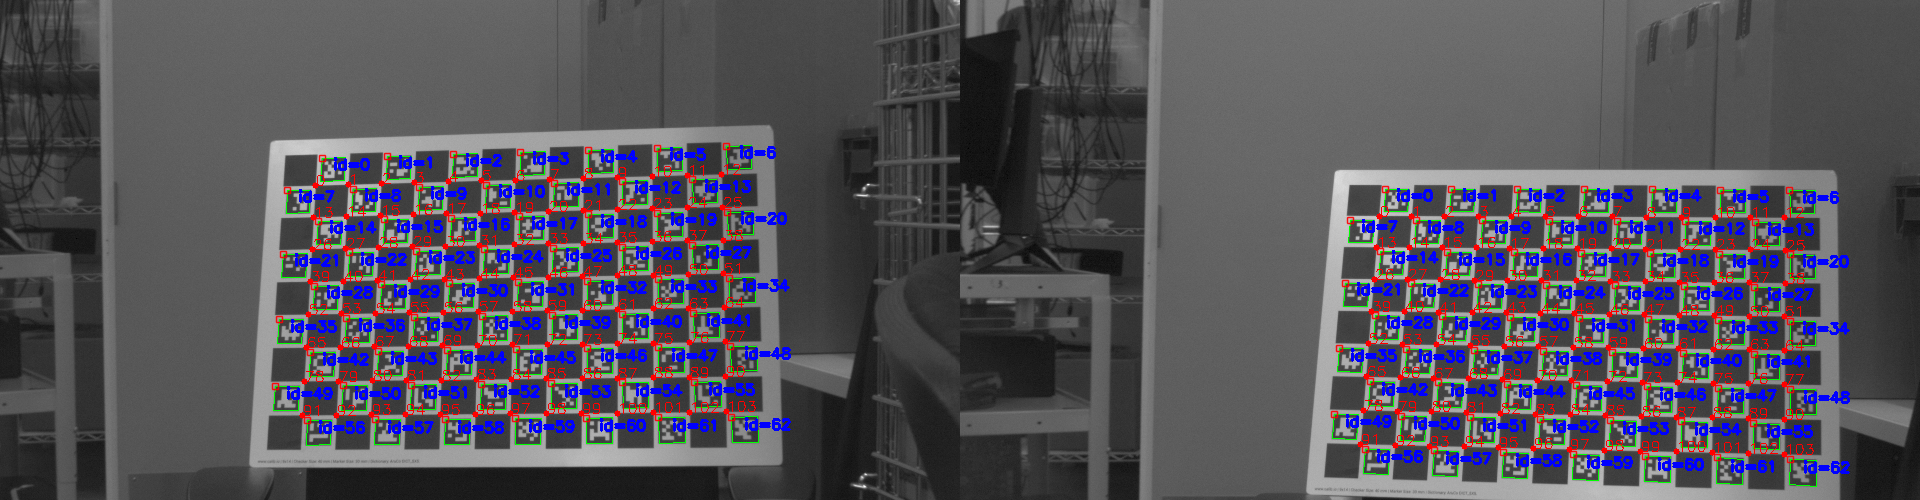


[INFO] The maximum of markers detected in the left images is 63 and the mininum of detected markers is 63.
[INFO] The maximum of markers IDs detected in the left images is 63 and the mininum of detected markers is 63.

[INFO] The maximum of corners detected in the left images is 104 and the mininum of detected corners is 104.
[INFO] The maximum of corners IDs detected in the left images is 104 and the mininum of detected corners is 104.

[INFO] The maximum of markers detected in the right images is 63 and the mininum of detected markers is 63.
[INFO] The maximum of markers IDs detected in the right images is 63 and the mininum of detected markers is 63.

[INFO] The maximum of corners detected in the right images is 104 and the mininum of detected corners is 104.
[INFO] The maximum of corners IDs detected in the right images is 104 and the mininum of detected corners is 104.


In [ ]:
''' For Verification that the markers are being detected in both images '''
## Loop over all images for statistics:
marker_list_left = []
marker_list_right = []
marker_ids_list_left = []
marker_ids_list_right = []

corner_list_left = []
corner_list_right = []
corner_ids_list_left = []
corner_ids_list_right = []

amount_markers_left_detected = []
amount_markers_left_detected_ids = []
amount_markers_right_detected = []
amount_markers_right_detected_ids = []
amount_corners_left_detected = []
amount_corners_left_detected_ids = []
amount_corners_right_detected = []
amount_corners_right_detected_ids = []

# For each image
good_image_left_paths = []
good_image_right_paths = []
for indx, [image_left, image_right] in enumerate(zip(image_left_paths, image_right_paths)):
  try:
    # Sweeping through all images
    sweep_img_left = cv2.imread(image_left)
    sweep_img_right = cv2.imread(image_right)

    # Detect ArUco markers in the image
    gray_left = cv2.cvtColor(sweep_img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(sweep_img_right, cv2.COLOR_BGR2GRAY)
    if MIRROR_MODE:
      # In the station mirror mode the charuco marker code is mirrored too.
      # So to accurately detect the marker code the input image to "detectBoard" needs to be flipped horizontally.
      # Once the marker code was processed all results need to be flipped back to their original form.
      gray_left = cv2.flip(gray_left, 1)
      gray_right = cv2.flip(gray_right, 1)

    charucodetector_left = cv2.aruco.CharucoDetector(charuco_board)
    corners_left, corner_ids_left, marker_corners_left, marker_ids_left = charucodetector_left.detectBoard(gray_left)
    charucodetector_right = cv2.aruco.CharucoDetector(charuco_board)
    corners_right, corner_ids_right, marker_corners_right, marker_ids_right = charucodetector_right.detectBoard(gray_right)

    # Make sure enough corners have been detected for the following calculations (estimating a value here):
    # if marker_ids_left is None or len(marker_ids_left) == 0:
    #   print(f"Image #{indx} left: No markers detected in left image: {np.shape(marker_ids_left)}.")
    # if marker_ids_right is None or len(marker_ids_right) == 0:
    #   print(f"Image #{indx} right: No markers detected in right image: {np.shape(marker_ids_right)}.")
    if len(corners_left) < 10 or len(corners_right) < 10:
      print(f"Image #{indx} left: Not enough corners detected in left image: {np.shape(corners_left)}.")
      continue

    # Collect the "good" samples
    good_image_left_paths.append(image_left)
    good_image_right_paths.append(image_right)

    # Determine how many markers and corners were detected in the left image
    amount_markers_left_detected.append(len(marker_corners_left))
    amount_markers_left_detected_ids.append(len(marker_ids_left))
    amount_corners_left_detected.append(len(corners_left))
    amount_corners_left_detected_ids.append(len(corner_ids_left))
    # Determine how many markers and corners were detected in the right image
    amount_markers_right_detected.append(len(marker_corners_right))
    amount_markers_right_detected_ids.append(len(marker_ids_right))
    amount_corners_right_detected.append(len(corners_right))
    amount_corners_right_detected_ids.append(len(corner_ids_right))

    # In mirror mode flip the results
    if MIRROR_MODE:
      # Flip charuco corners:
      corners_left = flip_corners_back(corners_left.squeeze(), 1, image_width, image_height)
      corners_right = flip_corners_back(corners_right.squeeze(), 1, image_width, image_height)
      # Flip marker corners:
      marker_corners_left = [flip_corners_back(marker.squeeze(), 1, image_width, image_height) for marker in marker_corners_left]
      marker_corners_right = [flip_corners_back(marker.squeeze(), 1, image_width, image_height) for marker in marker_corners_right]

    marker_list_left.append(marker_corners_left)
    marker_list_right.append(marker_corners_right)
    marker_ids_list_left.append(marker_ids_left)
    marker_ids_list_right.append(marker_ids_right)
    corner_list_left.append(corners_left)
    corner_list_right.append(corners_right)
    corner_ids_list_left.append(corner_ids_left)
    corner_ids_list_right.append(corner_ids_right)

    if indx == SAMPLE_TO_DISPLAY_NUMBER:
      sample_img_left = sweep_img_left.copy()
      sample_img_right = sweep_img_right.copy()
  except:
    pass

image_left_paths = good_image_left_paths
image_right_paths = good_image_right_paths

# Check if markers are detected
if marker_ids_left is not None and len(marker_ids_left) > 0 and marker_ids_right is not None and len(marker_ids_right) > 0:
  # Draw detected markers on the image for visualization
  img_left_markers = aruco.drawDetectedMarkers(sample_img_left, marker_list_left[SAMPLE_TO_DISPLAY_NUMBER], marker_ids_list_left[SAMPLE_TO_DISPLAY_NUMBER])
  img_right_markers = aruco.drawDetectedMarkers(sample_img_right, marker_list_right[SAMPLE_TO_DISPLAY_NUMBER], marker_ids_list_right[SAMPLE_TO_DISPLAY_NUMBER])

  # Add the interpolated corners to the image
  if corner_list_left is not None and len(corner_list_left) > 0:
    for corner_point, corner_id in zip(corner_list_left[SAMPLE_TO_DISPLAY_NUMBER], corner_ids_list_left[SAMPLE_TO_DISPLAY_NUMBER]):
      corner = [int(c) for c in corner_point[0]]
      cv2.circle(img_left_markers, corner, radius=3, color=(0, 0, 255), thickness=-1)
      cv2.putText(img_left_markers, str(corner_id[0]), corner, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

  if corner_list_right is not None and len(corner_list_right) > 0:
    for corner_point, corner_id in zip(corner_list_right[SAMPLE_TO_DISPLAY_NUMBER], corner_ids_list_right[SAMPLE_TO_DISPLAY_NUMBER]):
      corner = [int(c) for c in corner_point[0]]
      cv2.circle(img_right_markers, corner, radius=3, color=(0, 0, 255), thickness=-1)
      cv2.putText(img_right_markers, str(corner_id[0]), corner, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

  combined_image = np.concatenate([img_left_markers, img_right_markers], axis=1)
  cv2_imshow(combined_image)
else:
  print("[ERROR] No markers detected in left or right images.")
  if MIRROR_MODE:
    print("\tNote: MIRROR_MODE is set to True.")
  else:
    print("\tAre these mirrored images? If so, set MIRROR_MODE to True.")

print(f"\n[INFO] The maximum of markers detected in the left images is {max(amount_markers_left_detected)} and the mininum of detected markers is {min(amount_markers_left_detected)}.")
print(f"[INFO] The maximum of markers IDs detected in the left images is {max(amount_markers_left_detected_ids)} and the mininum of detected markers is {min(amount_markers_left_detected_ids)}.")

print(f"\n[INFO] The maximum of corners detected in the left images is {max(amount_corners_left_detected)} and the mininum of detected corners is {min(amount_corners_left_detected)}.")
print(f"[INFO] The maximum of corners IDs detected in the left images is {max(amount_corners_left_detected_ids)} and the mininum of detected corners is {min(amount_corners_left_detected_ids)}.")

print(f"\n[INFO] The maximum of markers detected in the right images is {max(amount_markers_right_detected)} and the mininum of detected markers is {min(amount_markers_right_detected)}.")
print(f"[INFO] The maximum of markers IDs detected in the right images is {max(amount_markers_right_detected_ids)} and the mininum of detected markers is {min(amount_markers_right_detected_ids)}.")

print(f"\n[INFO] The maximum of corners detected in the right images is {max(amount_corners_right_detected)} and the mininum of detected corners is {min(amount_corners_right_detected)}.")
print(f"[INFO] The maximum of corners IDs detected in the right images is {max(amount_corners_right_detected_ids)} and the mininum of detected corners is {min(amount_corners_right_detected_ids)}.")

## 2. Match Corresponding Corners Between Left and Right Images
Since each corner (as well as each marker) has a unique ID, detected corners can be matched between the left and the right image.

In [ ]:
# Convert ids to a flat array for easier processing
# For statistics collect over all images
corner_ids_list_left_flat = []
corner_ids_list_right_flat = []
common_ids_list = []

for idx, [ids_left, ids_right] in enumerate(zip(corner_ids_list_left, corner_ids_list_right)):
  ids_left = ids_left.flatten()
  ids_right = ids_right.flatten()
  corner_ids_list_left_flat.append(ids_left)
  corner_ids_list_right_flat.append(ids_right)

  # Find common marker IDs between left and right images
  common_ids = np.intersect1d(ids_left, ids_right)
  common_ids_list.append(common_ids)

## 3. Extract Corresponding Corner Points
For each common marker ID, extract the corner coordinates from both images

In [ ]:
points_common_list = []

# Loop through all images and get their determined marker and corner data...
for corners_left, corner_ids_left, corners_right, corner_ids_right, common_ids in zip(corner_list_left, corner_ids_list_left_flat, corner_list_right, corner_ids_list_right_flat, common_ids_list):
  corners_dict_left = corners_dict_right = {}
  corners_dict_left = {id_: corners for id_, corners in zip(corner_ids_left, corners_left) if id_ in common_ids}
  corners_dict_right = {id_: corners for id_, corners in zip(corner_ids_right, corners_right) if id_ in common_ids}

  points_common = {}
  for idxn in common_ids:
    points_common[idxn] = (corners_dict_left[idxn], corners_dict_right[idxn])
  points_common_list.append(points_common)

## 4. Extract Parameters from Calibration Data
Extract the parameters for both cameras.

For this exercise, the camera calibration was done using a Calibu chart. The calibration was done following the steps described in [this](https://docs.google.com/document/d/1nUxG2-sRL8YM3wsnlqll48YL8POIgJ6VQxjQ2N5RWPc/edit?usp=sharing) document.

In [ ]:
## Read the calibration data from the .rio file:
from google3.vr.stargate.calibration.python import camera_set_utils

'''
Parsing the .rio file:
The underlying class is in: vision/sfm/wrappers/python/camera.py
camera.py is called using vr/stargate/calibration/python/camera_set_utils.py
experimental/vr/stargate/display/python/calibration/camera_utils.py is the
function that calls camera_set_utils.py,
which contains the function load_camera_set.
'''
camera_calibration_data = camera_set_utils.load_camera_set(CALIBRATION_RIO_FILE)
cam_intrinsic_mat = {}
headline_txt = "Reading the intrinsic and extrinsic calibration data from the '.rio' file."
print("-" * len(headline_txt))
print(f"\033[1m{headline_txt}\033[0m")
print("-" * len(headline_txt))
for cam_key, value in camera_calibration_data.items():
  cam_intrinsic_mat[cam_key] = value.GetCalibrationMatrix()
  print(f"- Intrinsic Camera Matrix for \033[1m{cam_key}\033[0m: {cam_intrinsic_mat[cam_key]}.\n")

position = {}
orientation = {}
radialDistortion = {}
tangentialDistortion = {}
projection = {}

for cam_key, value in camera_calibration_data.items():
  position[cam_key] = value.GetPosition()
  orientation[cam_key] = value.GetOrientationAsAngleAxis()
  radialDistortion[cam_key] = [value.RadialDistortion1(), value.RadialDistortion2(), value.RadialDistortion3()]
  tangentialDistortion[cam_key] = [value.TangentialDistortion1(), value.TangentialDistortion2()]
  projection[cam_key] = value.ToProjectionMatrix()
  print(f"- Camera: \033[1m{cam_key}\033[0m")
  print(f"\tPosition for {cam_key}: {position[cam_key]}")
  print(f"\tOrientation for {cam_key}: {orientation[cam_key]}")
  print(f"\tRadial Distortion for {cam_key} : {radialDistortion[cam_key]}")
  print(f"\tTangential Distortion for {cam_key} : {tangentialDistortion[cam_key]}")
  print(f"\tProjection Matrix for {cam_key} : {projection[cam_key]}\n")

--------------------------------------------------------------------------
Reading the intrinsic and extrinsic calibration data from the '.rio' file.
--------------------------------------------------------------------------
- Intrinsic Camera Matrix for tracker0: [[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]].

- Intrinsic Camera Matrix for tracker1: [[ 1.72242982e+03 -9.82762339e-03  4.96852427e+02]
 [ 0.00000000e+00  1.72242891e+03  2.64195909e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]].

- Camera: tracker0
	Position for tracker0: [-0. -0. -0.]
	Orientation for tracker0: [0. 0. 0.]
	Radial Distortion for tracker0 : [-0.11464256927505012, 0.2616483563489396, 0.0]
	Tangential Distortion for tracker0 : [-0.000843235371967732, 0.0002367051062283764]
	Projection Matrix for tracker0 : [[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02  0.00000000e+00]
 [ 0.00000000e+00  1

## 5. Prepare Camera Matrices and Distortion Cooefficients


### a. Intrinsic Camera Matrices

In [ ]:
# Left camera:
K_left = np.array(cam_intrinsic_mat[camera_names[0]])

# Right camera:
K_right = np.array(cam_intrinsic_mat[camera_names[1]])
print(K_left)
print()
print(K_right)

[[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

[[ 1.72242982e+03 -9.82762339e-03  4.96852427e+02]
 [ 0.00000000e+00  1.72242891e+03  2.64195909e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### b. Construct Distortion Coefficient Arrays

In [ ]:
## Radial Distortion Coefficients
# Left camera:
k1_left = radialDistortion[camera_names[0]][0]    #radial_distortion_left_x
k2_left = radialDistortion[camera_names[0]][1]    #radial_distortion_left_y
k3_left = radialDistortion[camera_names[0]][2]    #radial_distortion_left_z

# Right camera:
k1_right = radialDistortion[camera_names[1]][0]    #radial_distortion_right_x
k2_right = radialDistortion[camera_names[1]][1]    #radial_distortion_right_y
k3_right = radialDistortion[camera_names[1]][2]    #radial_distortion_right_z

In [ ]:
## Tangential Distortion Coefficients
# Left camera:
p1_left = tangentialDistortion[camera_names[0]][0]    #tangential_distortion_left_x
p2_left = tangentialDistortion[camera_names[0]][1]    #tangential_distortion_left_y

# Right camera:
p1_right = tangentialDistortion[camera_names[1]][0]    #tangential_distortion_right_x
p2_right = tangentialDistortion[camera_names[1]][1]    #tangential_distortion_right_y

In [ ]:
## Distortion Coefficient Arrays
# Left camera:
dist_left = np.array([k1_left, k2_left, p1_left, p2_left, k3_left])
print(f"dist_left: {dist_left}")
# Right camera:
dist_right = np.array([k1_right, k2_right, p1_right, p2_right, k3_right])
print(f"dist_right: {dist_right}")

dist_left: [-1.14642569e-01  2.61648356e-01 -8.43235372e-04  2.36705106e-04
  0.00000000e+00]
dist_right: [-0.11098834  0.23621351  0.00043684 -0.00059739  0.        ]


## 6. Undistort the Points using OpenCV
Convert the points to the required format and undistort them if necessary.

In [ ]:
# Convert to numpy arrays
pts_left_list = []  # List of points to undistort
pts_right_list = []  # List of points to undistort
pts_left_undistorted_list = []  # List of points undistorted
pts_right_undistorted_list = []  # List of points undistorted
sequence_list = []  # List of sequence of points to undistort

# For each image
for point_dict in points_common_list:
  # Collect the corner-points in a list for this image to do the undistortion
  # Note: assuming here that the undistort function keeps the sequence of points as in the original dictionary
  sequence = []
  pts_left = []
  pts_right = []
  for indx, (pt_left, pt_right) in point_dict.items():
    sequence.append(indx)
    pts_left.append(pt_left)
    pts_right.append(pt_right)
  pts_left_list.append(pts_left)
  pts_right_list.append(pts_right)

  pts_left = np.array(pts_left, dtype=np.float32)  # Shape: (N, 2)
  pts_right = np.array(pts_right, dtype=np.float32)  # Shape: (N, 2)

  # Reshape pts_left and pts_right if they don't have a shape of (N, 1, 2):
  if pts_left.shape != (_, 1, 2):
    pts_left = pts_left.reshape(-1, 1, 2)
    pts_right = pts_right.reshape(-1, 1, 2)

  # Undistort the left and right images
  # print(f"pts_left: {pts_left.shape}")
  # print(f"pts_right: {pts_right.shape}")
  pts_left_undistorted = cv2.undistortPoints(pts_left, K_left, dist_left, P=K_left)
  pts_right_undistorted = cv2.undistortPoints(pts_right, K_right, dist_right, P=K_right)

  # Collect original sequence and undistorted points for the triangulation step
  sequence_list.append(sequence)
  pts_left_undistorted_list.append(pts_left_undistorted)
  pts_right_undistorted_list.append(pts_right_undistorted)
print(f"points_left_list: {pts_left_list[0]}")
print(f"points_right_list: {len(pts_right_list[0])}")


points_left_list: [array([[315.88248, 185.73334]], dtype=float32), array([[348.6476 , 184.81592]], dtype=float32), array([[381.54156, 183.88084]], dtype=float32), array([[414.72302, 182.8576 ]], dtype=float32), array([[448.0551 , 181.89961]], dtype=float32), array([[481.7161 , 180.90855]], dtype=float32), array([[515.35626, 180.04182]], dtype=float32), array([[549.38104, 179.0511 ]], dtype=float32), array([[583.62463, 178.08882]], dtype=float32), array([[617.9672 , 177.13943]], dtype=float32), array([[652.4739 , 176.22626]], dtype=float32), array([[687.1143 , 175.22638]], dtype=float32), array([[721.95264, 174.47234]], dtype=float32), array([[313.92966, 217.15404]], dtype=float32), array([[346.95288, 216.4082 ]], dtype=float32), array([[380.0162 , 215.65549]], dtype=float32), array([[413.3224 , 214.82846]], dtype=float32), array([[446.9917 , 213.88966]], dtype=float32), array([[480.8703 , 213.01157]], dtype=float32), array([[514.8554, 212.0881]], dtype=float32), array([[548.98724, 211.

## 7. Compute Projection Matrices

In [ ]:
# Identity rotation and zero translation for the left camera (assuming left camera as reference)
R_left = np.eye(3)
T_left = np.zeros((3, 1))

# For the right camera
# Orientation angles in radiants
orientation_right = np.array(orientation[camera_names[1]])

# # Create rotation object
# r = Rotation.from_euler('xyz', orientation_right)
# Get rotation matrix
# R_right = r.as_matrix()
R_right = cv2.Rodrigues(orientation_right)[0]

# Position vector
T_right = np.array([[position[camera_names[1]][0]], [position[camera_names[1]][1]], [position[camera_names[1]][2]]])

# Projection matrices
P_left = K_left @ np.hstack((R_left, T_left))
P_right = K_right @ np.hstack((R_right, T_right))

'''
Another way would be to use the results computed by the Camera class
(see below two lines).
However, it turned out that the above calculated results for P_left and
P_right are more accurate.
'''
# P_left = projection[camera_names[0]]
# P_right = projection[camera_names[1]]

# Display the results:
print(f"K_left: {K_left}")
print(f"K_right: {K_right}")
print(  f"R_left: {R_left}")
print(  f"T_left: {T_left}")
print(  f"R_right: {R_right}")
print(  f"T_right: {T_right}")
print(f"P_left: {P_left}")
print(f"P_right: {P_right}")

K_left: [[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
K_right: [[ 1.72242982e+03 -9.82762339e-03  4.96852427e+02]
 [ 0.00000000e+00  1.72242891e+03  2.64195909e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R_left: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T_left: [[0.]
 [0.]
 [0.]]
R_right: [[ 0.99941636 -0.03216722  0.01149792]
 [ 0.03199321  0.99937536  0.01501064]
 [-0.01197359 -0.01463403  0.99982122]]
T_right: [[-0.0620245 ]
 [ 0.00025914]
 [ 0.00093732]]
P_left: [[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02  0.00000000e+00]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
P_right: [[ 1.71547513e+03 -6.26865583e+01  5.16567813e+02 -1.06367149e+02]
 [ 5.19426593e+01  1.71748676e+03  2.90003444e+02  6.93994664e-01]
 [-1.19735885e-02 -1.46340279e-02  9.99821223e-01  9.37321944e-04]]


## 8. Triangulate 3D Points
Using cv2.triangulatePoints to triangulate the corresponding points and obtain 3D coordinates.

In [ ]:
# Triangulate points
points_3D_list = []
# For each image
for sequence, pts_left_undistorted, pts_right_undistorted in zip(sequence_list, pts_left_undistorted_list, pts_right_undistorted_list):
  x = [pts_left_undistorted, pts_right_undistorted]
  print(P_left)
  print(P_right)
  homogeneous_points = cv2.triangulatePoints(P_left, P_right, *x)

  # Convert homogeneous coordinates to 3D points
  points_3D = cv2.convertPointsFromHomogeneous(homogeneous_points.T)

  # Reshape to (N, 3)
  points_3D = points_3D.reshape(-1, 3)
  # print(points_3D.shape, points_3D)
  # break
  points_3D_dict = {}
  for indx, points_3D in zip(sequence, points_3D):
    points_3D_dict[indx] = points_3D
  points_3D_list.append(points_3D_dict)

print(f"points_3D_list: {points_3D_list[0]}")

[[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02  0.00000000e+00]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
[[ 1.71547513e+03 -6.26865583e+01  5.16567813e+02 -1.06367149e+02]
 [ 5.19426593e+01  1.71748676e+03  2.90003444e+02  6.93994664e-01]
 [-1.19735885e-02 -1.46340279e-02  9.99821223e-01  9.37321944e-04]]
points_3D_list: {np.int32(0): array([ 0.17717743,  0.08068182, -1.9840701 ], dtype=float32), np.int32(1): array([ 0.13886416,  0.08135349, -1.97387   ], dtype=float32), np.int32(2): array([ 0.10087503,  0.08203485, -1.9646705 ], dtype=float32), np.int32(3): array([ 0.06311432,  0.08298679, -1.9610507 ], dtype=float32), np.int32(4): array([ 0.0253145 ,  0.08382377, -1.9555132 ], dtype=float32), np.int32(5): array([-0.01262357,  0.0845591 , -1.9479982 ], dtype=float32), np.int32(6): array([-0.05009454,  0.08493859, -1.9345592 ], dtype=float32), np.int32(7): array([-0.08794402,  0.08587294, -

## 9. Validate the Calibration Accuracy

### 9.1 Reprojection Error Analysis

This tells you how accurately the 3D points derived from the calibration match their observed 2D projections on the image planes.


rvec_left = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
tvec_left = [[0.]
 [0.]
 [0.]]
rvec_right = [[ 0.99941636 -0.03216722  0.01149792]
 [ 0.03199321  0.99937536  0.01501064]
 [-0.01197359 -0.01463403  0.99982122]]
tvec_right = [[-0.0620245 ]
 [ 0.00025914]
 [ 0.00093732]]
K_left = [[ 1.73316025e+03 -8.48056195e-02  4.70515184e+02]
 [ 0.00000000e+00  1.73274475e+03  2.57157034e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
dist_coeffs_left = [-1.14642569e-01  2.61648356e-01 -8.43235372e-04  2.36705106e-04
  0.00000000e+00]
K_right = [[ 1.72242982e+03 -9.82762339e-03  4.96852427e+02]
 [ 0.00000000e+00  1.72242891e+03  2.64195909e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
dist_coeffs_right = [-0.11098834  0.23621351  0.00043684 -0.00059739  0.        ]
projected_points_left = [[[315.91095 186.75546]]

 [[348.67508 185.78288]]

 [[381.56885 184.83247]]

 [[414.75125 183.84694]]

 [[448.08356 182.89146]]

 [[481.74573 181.94969]]

 [[515.3862  181.09146]]

 [[549.41187 

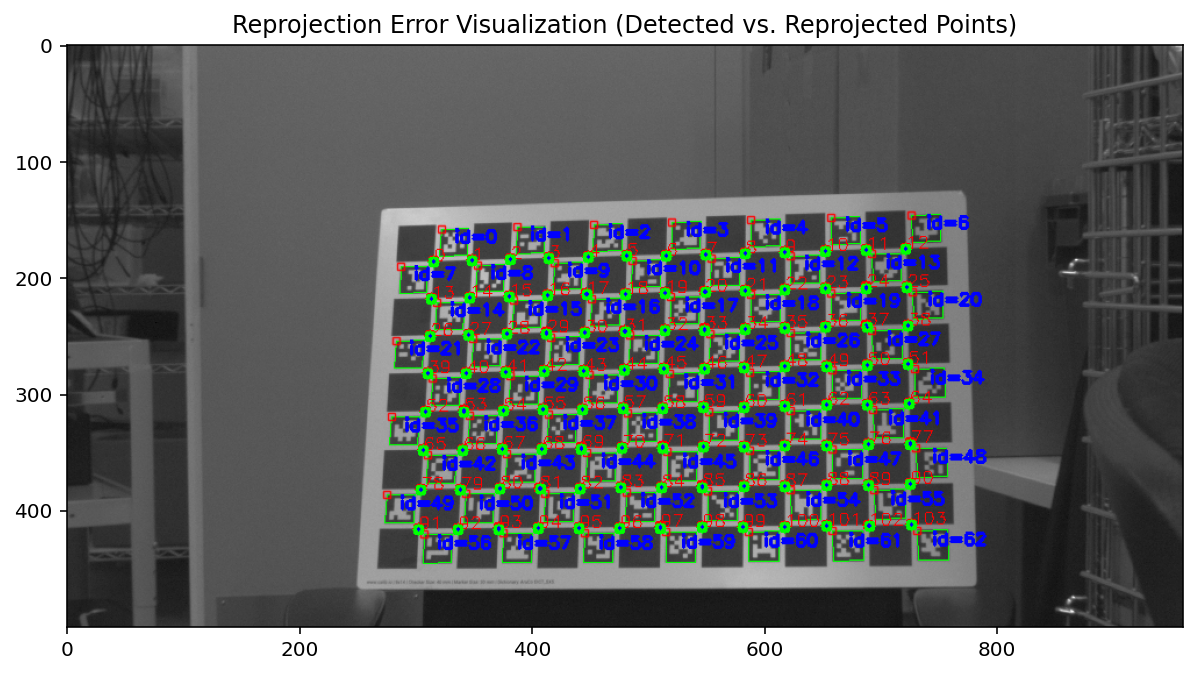

Arithmetic Mean Reprojection Error: 11.0767 pixels.
Reprojection Error Std Deviation: 0.0000 pixels.
Mean RMS Reprojection Error: 1.0862 pixels.
[ATTENTION] Based on the RMS reprojection error the calibration seems to be off and should be re-run.


In [ ]:
def calculate_reprojection_error(object_points, image_points_left, image_points_right,
                                 rvec_left, tvec_left, rvec_right, tvec_right,
                                 K_left, dist_coeffs_left, K_right, dist_coeffs_right,
                                 sample_index, sample_img_left=None):
  """
  Calculate the mean reprojection error for the stereo camera system.

  Parameters:
  object_points (list of ndarray): List of arrays of 3D points in the object space.
  image_points_left (list of ndarray): List of arrays of corresponding 2D points in the left camera images.
  image_points_right (list of ndarray): List of arrays of corresponding 2D points in the right camera images.
  rvec_left (ndarray): Rotation vector for the left camera.
  tvec_left (ndarray): Translation vector for the left camera.
  rvec_right (ndarray): Rotation vector for the right camera.
  tvec_right (ndarray): Translation vector for the right camera.
  K_left (ndarray): Intrinsic matrix for the left camera.
  dist_coeffs_left (ndarray): Distortion coefficients for the left camera.
  K_right (ndarray): Intrinsic matrix for the right camera.
  dist_coeffs_right (ndarray): Distortion coefficients for the right camera.

  Returns:
  float: Mean reprojection error.
  """
  total_error = 0
  total_points = 0
  errors = []

  print(f"rvec_left = {rvec_left}")
  print(f"tvec_left = {tvec_left}")
  print(f"rvec_right = {rvec_right}")
  print(f"tvec_right = {tvec_right}")
  print(f"K_left = {K_left}")
  print(f"dist_coeffs_left = {dist_coeffs_left}")
  print(f"K_right = {K_right}")
  print(f"dist_coeffs_right = {dist_coeffs_right}")

  # Ensure inputs are in the correct format
  object_points_list = []
  for allpoints in object_points:
    one_img_object_points_list = []
    for img_nr, points in allpoints.items():
      one_img_object_points_list.append(points)
    object_points_list.append(np.array(one_img_object_points_list, dtype=np.float32))

  image_points_left_list = []
  for all_left_points in image_points_left:
    image_points_left_list.append(np.array(all_left_points, dtype=np.float32).reshape(-1, 2))
  image_points_right_list = []
  for all_right_points in image_points_right:
    image_points_right_list.append(np.array(all_right_points, dtype=np.float32).reshape(-1, 2))

  # Iterate through each set of object points and corresponding image points
  # print(f"---------------->>>> len(object_points_list) = {len(object_points_list)}")
  for i in range(len(object_points_list)):
    # Project the 3D points into the left camera image using the calibration parameters
    projected_points_left, _ = cv2.projectPoints(
        object_points_list[i], rvec_left, tvec_left, K_left, dist_coeffs_left
    )
    print(f"projected_points_left = {projected_points_left}")
    # Reshape projected_points_left to match image_points_left_list[i] shape
    projected_points_left = projected_points_left.reshape(-1, 2)

    # Calculate the error between the detected points and the projected points for the left camera
    error_left = cv2.norm(image_points_left_list[i], projected_points_left, cv2.NORM_L2)

    # Project the 3D points into the right camera image using the calibration parameters
    projected_points_right, _ = cv2.projectPoints(
        object_points_list[i], rvec_right, tvec_right, K_right, dist_coeffs_right
    )
    print(f"projected_points_right = {projected_points_right}")
    # Reshape projected_points_right to match image_points_right_list[i] shape
    projected_points_right = projected_points_right.reshape(-1, 2)

    # print(f"image_points_right_list[i]  == {image_points_right_list[i]}")
    # Calculate the error between the detected points and the projected points for the right camera
    error_right = cv2.norm(image_points_right_list[i], projected_points_right, cv2.NORM_L2)
    # print(f"error_left = {error_left}")
    # print(f"error_right = {error_right}")

    # Sum the errors for both cameras
    total_error += error_left**2 + error_right**2
    total_points += len(object_points_list[i])

    total_image_error = (error_left + error_right) / 2
    errors.append(total_image_error)

    # Visualization for a sample image (left image)
    if i == sample_index and sample_img_left is not None:
      visualize_reprojection_error(sample_img_left, image_points_left_list[i], projected_points_left)

  # Calculate the root mean square (RMS) error
  rms_mean_error = np.sqrt(total_error / (2 * total_points))

  # Calculate the mean error
  mean_error = np.mean(errors)
  # Calculate the standard deviation of the reprojection errors
  std_deviation = np.std(errors)

  return rms_mean_error, mean_error, std_deviation


def visualize_reprojection_error(image, detected_points, reprojected_points):
  """
  Visualize the detected and reprojected points on an image, along with error lines.

  Parameters:
  image (ndarray): The original image.
  detected_points (ndarray): The detected points from the calibration.
  reprojected_points (ndarray): The reprojected points using calibration parameters.
  """
  # Create a copy of the image for visualization
  vis_image = image.copy()

  # Draw the detected corners (in red)
  for pt in detected_points:
    cv2.circle(vis_image, (int(pt[0]), int(pt[1])), 5, (0, 0, 255), -1)  # Red circle for detected points

  # Draw the reprojected points (in green)
  for pt in reprojected_points:
    cv2.circle(vis_image, (int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)  # Green circle for reprojected points

  # Draw error bars (lines connecting detected points and reprojected points)
  for detected, reprojected in zip(detected_points, reprojected_points):
    cv2.line(vis_image, (int(detected[0]), int(detected[1])), (int(reprojected[0]), int(reprojected[1])), (255, 0, 0), 2)

  # Display the image with error bars
  plt.figure(figsize=(10, 8))
  plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
  plt.title('Reprojection Error Visualization (Detected vs. Reprojected Points)')
  plt.show()

# Call
rms_mean_reprojection_error, mean_error, reprojection_error_std = calculate_reprojection_error(
    points_3D_list, pts_left_list, pts_right_list,
    R_left, T_left, R_right, T_right,
    cam_intrinsic_mat[camera_names[0]], dist_left, cam_intrinsic_mat[camera_names[1]], dist_right,
    SAMPLE_TO_DISPLAY_NUMBER, sample_img_left
)

print(f"Arithmetic Mean Reprojection Error: {mean_error:.4f} pixels.")
print(f"Reprojection Error Std Deviation: {reprojection_error_std:.4f} pixels.")
print(f"Mean RMS Reprojection Error: {rms_mean_reprojection_error:.4f} pixels.")
if rms_mean_reprojection_error > REPROJECTION_ERROR_LIMIT:
  print(f"\033[1m[ATTENTION] Based on the RMS reprojection error the calibration seems to be off and should be re-run.\033[0m")
  CALIBRATION_IS_ACCURATE = False
else:
  print("[INFO] Based on the RMS reprojection error the calibration seems accurate.")
  CALIBRATION_IS_ACCURATE = True

### 9.2 Calculate the Reprojection Error using Epipolar Lines

* Helper-Functions:

In [ ]:
def normalized_to_pixel_coordinates(points, K):
  """
  Convert normalized points to pixel coordinates.
  """
  # points_h = cv2.convertPointsToHomogeneous(points).reshape(-1, 3)
  ones = np.ones((points.shape[0], 1))
  points_h = np.hstack([points, ones])
  points_pixel = (K @ points_h.T).T    # Project back to pixel coordinates
  return points_pixel[:, :2]

def calculate_skew_symmetric_matrix(T):
  """
  Create a skew-symmetric matrix from a 3D translation vector T.
  """
  T = T.flatten()
  T_x = np.array([
      [0, -T[2], T[1]],
      [T[2], 0, -T[0]],
      [-T[1], T[0], 0]
  ])
  return T_x

def calculate_closest_point_on_line(point, line):
  """ Calculate the closest point on an epipolar line to a given point.

  Parameters:
  point (ndarray): 2D feature point in image coordinates.
  line (ndarray): Epipolar line coefficients [a, b, c].

  Returns:
  ndarray: Closest point on the epipolar line.
  """
  a, b, c = line
  x, y = point

  # Normal to the line
  norm = np.array([a, b])

  # Calculate the closest point on the line
  closest_point = point - ( a * x + b * y + c) / (a**2 + b**2) * norm
  return closest_point

* Calculation of the epipolar error in pixels:

In [ ]:
def calculate_epipolar_constraint_error(image_points_left, image_points_right, K_left, K_right, dist_coeff_left, dist_coeff_right, R, T):
  """
  Calculate the mean epipolar constraint error for the stereo camera system.

  Parameters:
  image_points_left (list of ndarray): List of arrays of corresponding 2D points in the left camera images.
  image_points_right (list of ndarray): List of arrays of corresponding 2D points in the right camera images.
  K_left (ndarray): Intrinsic matrix for the left camera.
  K_right (ndarray): Intrinsic matrix for the right camera.
  R (ndarray): Rotation matrix from the left camera to the right camera.
  T (ndarray): Translation vector from the left camera to the right camera.

  Returns:
  float: Mean epipolar constraint error.
  """
  # Calculate the Essential matrix (E) using the rotation and translation
  # Create the skew-symmetric matrix of T
  T_x = calculate_skew_symmetric_matrix(T)

  # Calculate the Essential matrix (E)
  E = R @ T_x
  print(f"Essential matrix: {E}")

  # Compute the Fundamental matrix (F) from the Essential matrix (E)
  F = np.dot(np.linalg.inv(K_right).T, np.dot(E, np.linalg.inv(K_left)))
  print(f"Fundamental matrix: {F}")

  total_error = 0
  total_points = 0
  total_angle_deviation = 0

  # For each image: Iterate through each set of image points
  for i in range(len(image_points_left)):
    # Undistory and reproject to pixel coordinates
    points_left = [normalized_to_pixel_coordinates(
                            cv2.undistortPoints(np.array(points, dtype=np.float32).reshape(-1, 2), K_left, dist_coeff_left).reshape(-1, 2),
                            K_left
                        ) for points in image_points_left[i]]
    print(f"points_left = {points_left}")
    points_right = [normalized_to_pixel_coordinates(
                            cv2.undistortPoints(np.array(points, dtype=np.float32).reshape(-1, 2), K_right, dist_coeff_right).reshape(-1, 2),
                            K_right
                        ) for points in image_points_right[i]]
    points_left = np.squeeze(points_left)
    points_right = np.squeeze(points_right)

    # Convert points to homogeneous coordinates
    points_left_h = cv2.convertPointsToHomogeneous(points_left)
    points_right_h = cv2.convertPointsToHomogeneous(points_right)

    # Compute epilines for points in the left image (as seen in the right image)
    lines_right = cv2.computeCorrespondEpilines(points_left_h, 1, F)
    lines_right = lines_right.reshape(-1, 3)

    # Compute epilines for points in the right image (as seen in the left image)
    lines_left = cv2.computeCorrespondEpilines(points_right_h, 2, F)
    lines_left = lines_left.reshape(-1, 3)
    # print(f"lines_left: {lines_left}, lines_right: {lines_right}")

    # Calculate distance from points to their corresponding epipolar lines
    for j in range(len(points_left)):
      # Epipolar line: ax + by + c = 0
      # Distance formula: |ax + by + c| / sqrt(a^2 + b^2)

      # Distance of right point from its corresponding epipolar line in the left image
      a1, b1, c1 = lines_left[j]
      x1, y1 = points_left[j]
      distance_left = abs(a1 * x1 + b1 * y1 + c1) / np.sqrt(a1**2 + b1**2)

      # Distance of left point from its corresponding epipolar line in the right image
      a2, b2, c2 = lines_right[j]
      x2, y2 = points_right[j]
      distance_right = abs(a2 * x2 + b2 * y2 + c2) / np.sqrt(a2**2 + b2**2)

      # Sum the distances for error calculation
      total_error += distance_left + distance_right
      total_points += 2

      # Calculate the angle deviation between the point and the epipolar line (left camera)
      norm_left = np.array([a1, b1])
      norm_left = norm_left / np.linalg.norm(norm_left)
      point_vector_left = np.array([x1, y1])
      cos_theta_left = np.dot(point_vector_left, norm_left) / (np.linalg.norm(point_vector_left) * np.linalg.norm(norm_left))
      angle_left = np.arccos(np.clip(cos_theta_left, -1.0, 1.0))  # Clip for numerical stability

      # Calculate the angle deviation between the point and the epipolar line (right camera)
      norm_right = np.array([a2, b2])
      norm_right = norm_right / np.linalg.norm(norm_right)
      point_vector_right = np.array([x2, y2])
      cos_theta_right = np.dot(point_vector_right, norm_right) / (np.linalg.norm(point_vector_right) * np.linalg.norm(norm_right))
      angle_right = np.arccos(np.clip(cos_theta_right, -1.0, 1.0))
      # print(f"cos_theta_right: {cos_theta_right}, cos_theta_left: {cos_theta_left}")

      total_angle_deviation += np.degrees(angle_left) + np.degrees(angle_right)
      # print(f"Angles left: {angle_left}, {np.degrees(angle_left)}, right: {angle_right}, {np.degrees(angle_right)} --> {total_angle_deviation} degrees")

  # Calculate the average epipolar error
  mean_error = total_error / total_points
  mean_angle_deviation = total_angle_deviation / total_points

  return mean_error, mean_angle_deviation

# Call
mean_epipolar_error, mean_angle_deviation = calculate_epipolar_constraint_error(
    pts_left_list, pts_right_list, cam_intrinsic_mat[camera_names[0]], cam_intrinsic_mat[camera_names[1]], dist_left, dist_right, R_right, T_right
)

print(f"Mean Epipolar Constraint Error: {mean_epipolar_error:.4f} pixels")
print(f"Mean Angle Deviation from 90deg: {mean_angle_deviation:.4f} degrees")
print("\tNote: In the ideal case, when the point lies on the epipolar line, the angle deviation to the normal is 90 degrees.")
if mean_epipolar_error > REPROJECTION_ERROR_LIMIT:
  print(f"\033[1m[ATTENTION] Based on the mean epipolar error the calibration seems to be off and should be re-run.\033[0m")
  CALIBRATION_IS_ACCURATE = False
else:
  print("[INFO] Based on the mean epipolar error the calibration seems accurate.")

Essential matrix: [[-3.31306673e-05 -1.64992767e-03 -1.73616280e-03]
 [ 9.32846531e-04 -9.61015706e-04  6.19940530e-02]
 [-2.72815004e-04 -6.20021933e-02 -9.10771228e-04]]
Fundamental matrix: [[-1.10981330e-11 -5.52826947e-10 -8.60587847e-07]
 [ 3.12485657e-10 -3.21986908e-10  3.59279936e-05]
 [-2.34452287e-07 -3.54229133e-05 -6.99390410e-04]]
points_left = [array([[315.71823896, 185.67185986]]), array([[348.5607406 , 184.77366915]]), array([[381.50279646, 183.85393172]]), array([[414.71038143, 182.84170737]]), array([[448.05419613, 181.89001781]]), array([[481.72067914, 180.90012123]]), array([[515.36858091, 180.02913179]]), array([[549.41226273, 179.02830048]]), array([[583.69486393, 178.04989376]]), array([[618.10525879, 177.07829059]]), array([[652.71712159, 176.13678052]]), array([[687.50828665, 175.10231879]]), array([[722.55023719, 174.30829849]]), array([[313.7739827, 217.1274254]]), array([[346.87433714, 216.39065752]]), array([[379.98427993, 215.64536585]]), array([[413.31421

## 9.3 Determine the Dipvergence
1. **Undistort Points from Left and Right cameras:** The image points need to be corrected for radial and for tangential distortion. Radial distortion causes image points to move radially outward or inward from the center of the image. Tangential distortion occurs when the lens and image plane are not perfectly parallel, causing points to shift tangentially. The calibration provides the intrinsic matrix and distortion coefficients to map distorted points back to their corrected locations.
The undistortion step returns normalizes values. For consistency, these values need to be projected back into pixel coordinates using the intrinsic matrix $K$.
2. **First Ray**: This ray is from the camera center through the feature point in the image. The direction vector for this ray can be found by back-projecting the feature point into 3D space, using the inverse of the intrinsic matrix $K$.\
If the 2D feature point in image coordinates is $\vec{p} = (x, y)$, the corresponding 3D direction vector (in the camera coordinat system) can be computed as:
$$\vec{r_1} = K^{-1} \cdot \vec{p_h}$$
where $\vec{p_h}=[x, y, 1]^T$ is the homogeneous representation of the 2D point.
2. **Second Ray**: Find for this ray the closest point on the epipolar line to the feature point. This can be found by projecting the feature point perpendicularly onto the epipolar line.\
The epipolar line equation is given by $ax + by + c = 0$. The closest point $\vec{p}_{closest}$ on the line to the feature point $\vec{p}$ can be computed as:
$$\vec{p}_{closest} = \vec{p} - \frac{ax + by + c}{a^2 + b^2} \cdot  \vec{n}$$
where $\vec{n} = [a, b]^T$ is the normal to the epipolar line.
3. **Second Ray Direction Vector**: The direction of the second ray $\vec{r_2}$ is found by back-projecting the closest point **$p_{closest}$** into 3D using the same approach as Step 1.
4. **Angle Between Rays**: Finally, the angle $\theta$ between the two rays can be computed using the dot product:
$$\cos(\theta) = \frac{\vec{r_1} \cdot \vec{r_2}}{|\vec{r_1}| \cdot |\vec{r_2}|}$$
and the angle is given by:
$$ \theta = \arccos(\cos(\theta))$$

In [ ]:
def calculate_epipolar_constraint_error_with_dipvergence(image_points_left, image_points_right, K_left, K_right, dist_coeff_left, dist_coeff_right, R, T):
  """ Calculate epipolar error and dipvergence angle, accounting for radial and tangential distortions """
  T_x = calculate_skew_symmetric_matrix(T)
  E = R @ T_x
  F = np.dot(np.linalg.inv(K_right).T, np.dot(E, np.linalg.inv(K_left)))
  print(F)

  # total_error = 0
  total_points = 0
  total_angle_deviation = 0

  # For each image: Looking at the Left-to-Right and the Right-to-Left Dipvergence
  for i in range(len(image_points_left)):
    points_left = [normalized_to_pixel_coordinates(
                            cv2.undistortPoints(np.array(points, dtype=np.float32).reshape(-1, 2), K_left, dist_coeff_left).reshape(-1, 2),
                            K_left
                        ) for points in image_points_left[i]]
    points_right = [normalized_to_pixel_coordinates(
                            cv2.undistortPoints(np.array(points, dtype=np.float32).reshape(-1, 2), K_right, dist_coeff_right).reshape(-1, 2),
                            K_right
                        ) for points in image_points_right[i]]
    points_left = np.squeeze(points_left)
    points_right = np.squeeze(points_right)
    points_left_h = cv2.convertPointsToHomogeneous(points_left)
    points_right_h = cv2.convertPointsToHomogeneous(points_right)

    # # Left-to-Right Dipvergence
    # lines_right = cv2.computeCorrespondEpilines(points_left_h, 1, F).reshape(-1, 3)
    # for j in range(len(points_left)):
    #   x1, y1 = points_left[j]
    #   point_left_h = np.array([x1, y1, 1])
    #   ray_1 = np.linalg.inv(K_left) @ point_left_h

    #   line_right = lines_right[j]
    #   closest_point_right = calculate_closest_point_on_line(np.array([x1, y1]), line_right)
    #   closest_point_right_h = np.array([closest_point_right[0], closest_point_right[1], 1])
    #   ray_2 = np.linalg.inv(K_right) @ closest_point_right_h

    #   ray_1_norm = ray_1 / np.linalg.norm(ray_1)
    #   ray_2_norm = ray_2 / np.linalg.norm(ray_2)

    #   cos_theta = np.dot(ray_1_norm, ray_2_norm)
    #   angle_dipvergence = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    #   total_angle_deviation += np.degrees(angle_dipvergence)
    #   total_points += 1
    # Left-to-Right Divergence
    lines_right = cv2.computeCorrespondEpilines(points_left_h, 1, F).reshape(-1, 3)
    for j in range(len(points_left)):
      # Get the right point and the epipolar line
      x2, y2 = points_right[j]
      point_right_h = np.array([x2, y2, 1])

      # Find the closest point on the epipolar line in the right image
      line_right = lines_right[j]
      closest_point_right = calculate_closest_point_on_line(np.array([x2, y2]), line_right)
      closest_point_right_h = np.array([closest_point_right[0], closest_point_right[1], 1])

      # Calculate rays from the origin to the actual right point and the closest point on the epipolar line
      ray_actual_right = np.linalg.inv(K_right) @ point_right_h
      ray_closest_right = np.linalg.inv(K_right) @ closest_point_right_h

      # Normalize rays for angle calculation
      ray_actual_right_norm = ray_actual_right / np.linalg.norm(ray_actual_right)
      ray_closest_right_norm = ray_closest_right / np.linalg.norm(ray_closest_right)

      # Calculate divergence angle
      cos_theta = np.dot(ray_actual_right_norm, ray_closest_right_norm)
      angle_divergence = np.arccos(np.clip(cos_theta, -1.0, 1.0))

      total_angle_deviation += np.degrees(angle_divergence)
      total_points += 1

    # # Right-to-Left Dipvergence
    # lines_left = cv2.computeCorrespondEpilines(points_right_h, 2, F).reshape(-1, 3)
    # for j in range(len(points_right)):
    #   x2, y2 = points_right[j]
    #   point_right_h = np.array([x2, y2, 1])
    #   ray_1 = np.linalg.inv(K_right) @ point_right_h

    #   line_left = lines_left[j]
    #   closest_point_left = calculate_closest_point_on_line(np.array([x2, y2]), line_left)
    #   closest_point_left_h = np.array([closest_point_left[0], closest_point_left[1], 1])
    #   ray_2 = np.linalg.inv(K_left) @ closest_point_left_h

    #   ray_1_norm = ray_1 / np.linalg.norm(ray_1)
    #   ray_2_norm = ray_2 / np.linalg.norm(ray_2)

    #   cos_theta = np.dot(ray_1_norm, ray_2_norm)
    #   angle_dipvergence = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    #   total_angle_deviation += np.degrees(angle_dipvergence)
    #   total_points += 1
    # Right-to-Left Divergence
    lines_left = cv2.computeCorrespondEpilines(points_right_h, 2, F).reshape(-1, 3)
    for j in range(len(points_right)):
      # Get the left point and the epipolar line
      x1, y1 = points_left[j]
      point_left_h = np.array([x1, y1, 1])

      # Find the closest point on the epipolar line in the left image
      line_left = lines_left[j]
      closest_point_left = calculate_closest_point_on_line(np.array([x1, y1]), line_left)
      closest_point_left_h = np.array([closest_point_left[0], closest_point_left[1], 1])

      # Calculate rays from the origin to the actual left point and the closest point on the epipolar line
      ray_actual_left = np.linalg.inv(K_left) @ point_left_h
      ray_closest_left = np.linalg.inv(K_left) @ closest_point_left_h

      # Normalize rays for angle calculation
      ray_actual_left_norm = ray_actual_left / np.linalg.norm(ray_actual_left)
      ray_closest_left_norm = ray_closest_left / np.linalg.norm(ray_closest_left)

      # Calculate divergence angle
      cos_theta = np.dot(ray_actual_left_norm, ray_closest_left_norm)
      angle_divergence = np.arccos(np.clip(cos_theta, -1.0, 1.0))

      total_angle_deviation += np.degrees(angle_divergence)
      total_points += 1

  mean_angle_deviation = total_angle_deviation / total_points

  return mean_angle_deviation

# Call
mean_angle_deviation = calculate_epipolar_constraint_error_with_dipvergence(
    pts_left_list, pts_right_list, cam_intrinsic_mat[camera_names[0]], cam_intrinsic_mat[camera_names[1]], dist_left, dist_right, R_right, T_right
)

print(f"\033[1m[INFO] The mean Dipvergence Angle is {mean_angle_deviation:.4f} degrees.\033[0m")

[[-1.10981330e-11 -5.52826947e-10 -8.60587847e-07]
 [ 3.12485657e-10 -3.21986908e-10  3.59279936e-05]
 [-2.34452287e-07 -3.54229133e-05 -6.99390410e-04]]
[INFO] The mean Dipvergence Angle is 0.0117 degrees.


## 10. Determine the Board Dimensions
Analyze the distances to determine the size of the board.
- **Square Size:** The markers are arranged in a grid, so the minimum distance between adjacent corners is the size of one side of a square.
- **Board Width and Height:** Using the position of the outermost markers or corners to calculate the overall dimensions.

In [ ]:
# Create one dictionary for indices per row and one dictionary for indices per column
row_idx_dict = {r: list(range(r * (SQUARES_HORIZONTALLY - 1), (r + 1) *
                              (SQUARES_HORIZONTALLY - 1)))
                for r in range(SQUARES_VERTICALLY - 1)}
# ===================================================
column_idx_dict = {c: [c + r * (SQUARES_HORIZONTALLY - 1)
                        for r in range(SQUARES_VERTICALLY - 1)]
                    for c in range(SQUARES_HORIZONTALLY - 1)}
# # For evaluation make sure the corner id dictionaries are correct:
# for key, value in row_idx_dict.items():
#   print(f"Row {key}: {value}")
# for key, value in column_idx_dict.items():
#   print(f"Column {key}: {value}")

In [ ]:
# # Calculate the widths using the 3D triangulation points
# width_3d_list = []
# height_3d_list = []

# # For each image
# width_3d_list = []
# height_3d_list = []
# for img_nr, points_3D_dict in enumerate(points_3D_list):
#   average_row_lengths_list = []
#   # Iterate over each row in the board
#   for row_corners in row_idx_dict.values():
#       # Filter out indices that are not in points_3d_dict
#       available_indices = [idx for idx in row_corners if idx in points_3D_dict]
#       # Sort the indices to maintain order
#       available_indices.sort()
#       # print(available_indices)
#       # Compute distances between adjacent points
#       for i in range(len(available_indices) - 1):
#           idx1 = available_indices[i]
#           idx2 = available_indices[i + 1]
#           # Calculate the distance between adjacent points
#           # if (idx2-idx1) > 1:
#           #   continue
#           distance = np.linalg.norm(points_3D_dict[idx1] - points_3D_dict[idx2])/(idx2-idx1)
#           # print(distance)
#           average_row_lengths_list.append(distance)

#   # Calculate the average distance between adjacent squares
#   if average_row_lengths_list:
#       average_distance = sum(average_row_lengths_list) / len(average_row_lengths_list)
#       # print(f"average_distance = {average_distance}")
#       # Multiply by the number of squares horizontally to get the total width
#       width_measured = SQUARES_HORIZONTALLY * average_distance
#   else:
#       width_measured = 0  # Or handle this case appropriately

#   # Output the measured width
#   print(f"Measured width of the charuco board: {width_measured}")

#   # Initialize a list to collect vertical distances between adjacent points
#   average_column_lengths_list = []

#   # Iterate over each column in the board
#   for column_corners in column_idx_dict.values():
#     # Filter out indices that are not in points_3d_dict
#     available_indices = [idx for idx in column_corners if idx in points_3D_dict]
#     # Sort the indices to maintain order (from top to bottom)
#     available_indices.sort()
#     # print(available_indices)
#     # Compute distances between adjacent points
#     for i in range(len(available_indices) - 1):
#       idx1 = available_indices[i]
#       idx2 = available_indices[i + 1]
#       # if (idx2-idx1) > 16:
#       #   continue
#       # Calculate the distance between adjacent points
#       distance = np.linalg.norm(points_3D_dict[idx1] - points_3D_dict[idx2]) / (idx2 - idx1 - (SQUARES_HORIZONTALLY - 2))
#       # print(distance)
#       average_column_lengths_list.append(distance)

#   # Calculate the average distance between adjacent squares vertically
#   if average_column_lengths_list:
#     average_vertical_distance = sum(average_column_lengths_list) / len(average_column_lengths_list)
#     # Multiply by the number of squares vertically to get the total height
#     height_measured = SQUARES_VERTICALLY * average_vertical_distance
#     # print(f"average_vertical_distance = {average_vertical_distance}")
#   else:
#     height_measured = 0  # Handle the case when no distances are available

#   # Output the measured height
#   print(f"#{img_nr}: Measured height of the charuco board: {height_measured}")

#   width_3d_list.append((img_nr, width_measured))
#   height_3d_list.append((img_nr, height_measured))
#   print("-----------------------------------------------------------------------")


In [ ]:
# Caluclate the real dimensions of the board in 3D space
print("[INFO] Board width and height in 3D space:")
one_square_side = SQUARE_LENGTH   # in meters
width_3d_img_dict = {}
height_3d_img_dict = {}
width_3d_list = []
height_3d_list = []

img_max_row_ids = {}
img_max_col_ids = {}

# Prepare row index and column index dictionaries
# These dictionaries contain the indices for the corners sorted in rows and in columns
row_idx_dict = {}
row_idx = 0
while row_idx < SQUARES_VERTICALLY - 1:
  indx_start = row_idx * (SQUARES_HORIZONTALLY - 1)
  indx_end = (row_idx + 1) * (SQUARES_HORIZONTALLY - 1)
  row_idx_dict[row_idx] = []
  for indx in range(indx_start, indx_end):
    row_idx_dict[row_idx].append(indx)
  row_idx += 1
# ===================================================
column_idx_dict = {}
column_idx = 0
while column_idx < (SQUARES_HORIZONTALLY-1):
  indx_start = column_idx
  indx_end = (column_idx + 1) + ((SQUARES_HORIZONTALLY-1) * (SQUARES_VERTICALLY-1) - (SQUARES_HORIZONTALLY-1))
  column_idx_dict[column_idx] = []
  for indx in range(indx_start, indx_end, SQUARES_HORIZONTALLY-1):
    column_idx_dict[column_idx].append(indx)
  column_idx += 1
# ===================================================

# For each image
horizontal_end_points_per_img = {}
vertical_end_points_per_img = {}
common_image_nr_with_complete_row_and_col = []
for img_nr, points_3D_dict in enumerate(points_3D_list):
  try:
    # Using the row dictionary compute per row the average distances between all available corner coordinates
    average_row_legths_list = []
    for row_idx, row_corners in row_idx_dict.items():
      # Calculate the average distance between each pair of available indices
      for i in range(len(row_corners)-1):
        if row_corners[i] not in points_3D_dict:
          continue
        for j in range(i+1, len(row_corners)):
          if row_corners[j] not in points_3D_dict:
            continue
          average_row_legths_list.append(np.linalg.norm(points_3D_dict[row_corners[i]] - points_3D_dict[row_corners[j]]) / (j - i))
    width_measured = SQUARES_HORIZONTALLY * sum(average_row_legths_list)/len(average_row_legths_list)
    # --------------------------------------------------------------------

    # Using the column dictionary compute per column the average distance between all available corner coordinates
    average_column_legths_list = []
    for column_idx, column_corners in column_idx_dict.items():
      # Calculate the average distance between each pair of available indices
      for i in range(len(column_corners)-1):
        if column_corners[i] not in points_3D_dict:
          continue
        for j in range(i+1, len(column_corners)):
          if column_corners[j] not in points_3D_dict:
            continue
          average_column_legths_list.append(np.linalg.norm(points_3D_dict[column_corners[i]] - points_3D_dict[column_corners[j]]) / (j - i))
    height_measured = SQUARES_VERTICALLY * sum(average_column_legths_list)/len(average_column_legths_list)
    # ====================================================================
    # print(f"width_measured: {width_measured*100:.4f}cm, height_measured: {height_measured*100:.4f}cm")
    # For this image (if possible) find the coordinates for row 0 corner 0 and corner -1
    image_nr_with_complete_row = []
    image_nr_with_complete_col = []
    for _, row_idx in row_idx_dict.items():
      if row_idx[0] in sequence_list[img_nr] and row_idx[-1] in sequence_list[img_nr]:
        indx_start_idx = sequence_list[img_nr].index(row_idx[0])
        indx_end_idx = sequence_list[img_nr].index(row_idx[-1])

        start_width_coord = pts_left_list[img_nr][indx_start_idx][0]
        end_width_coord = pts_left_list[img_nr][indx_end_idx][0]

        horizontal_end_points_per_img[img_nr] = [start_width_coord, end_width_coord]
        image_nr_with_complete_row.append(img_nr)
        break
    for _, col_idx in column_idx_dict.items():
      if col_idx[0] in sequence_list[img_nr] and col_idx[-1] in sequence_list[img_nr]:
        indx_start_idx = sequence_list[img_nr].index(col_idx[0])
        indx_end_idx = sequence_list[img_nr].index(col_idx[-1])

        start_height_coord = pts_left_list[img_nr][indx_start_idx][0]
        end_height_coord = pts_left_list[img_nr][indx_end_idx][0]

        vertical_end_points_per_img[img_nr] = [start_height_coord, end_height_coord]
        image_nr_with_complete_col.append(img_nr)
        break
  except:
    width_measured = None
    height_measured = None
    pass
  # Collect the found dimensions for each image
  width_3d_img_dict[img_nr] = width_measured
  height_3d_img_dict[img_nr] = height_measured
  width_3d_list.append((img_nr, width_measured))
  height_3d_list.append((img_nr, height_measured))

  # For the later display, collect the image number of the images that can be used to
  # display both, width and height
  col_and_row_have_ends = np.intersect1d(image_nr_with_complete_row, image_nr_with_complete_col)
  if col_and_row_have_ends.size > 0:
    common_image_nr_with_complete_row_and_col.extend(list(col_and_row_have_ends))

print(f"horizontal_end_points_per_img: {horizontal_end_points_per_img}")
print(f"vertical_end_points_per_img: {vertical_end_points_per_img}")
print(f"common_image_nr_with_complete_row_and_col: {common_image_nr_with_complete_row_and_col}")

[INFO] Board width and height in 3D space:
horizontal_end_points_per_img: {0: [array([315.88248, 185.73334], dtype=float32), array([721.95264, 174.47234], dtype=float32)]}
vertical_end_points_per_img: {0: [array([315.88248, 185.73334], dtype=float32), array([302.7909 , 415.33157], dtype=float32)]}
common_image_nr_with_complete_row_and_col: [np.int64(0)]


## 11. Calculate Statistics
Compare the calculated 3-D dimensions of the ChArUco board with the ground-truth dimensions.

[ERROR] The Calibration seems off and hence the calculated dimensions are not accurate.


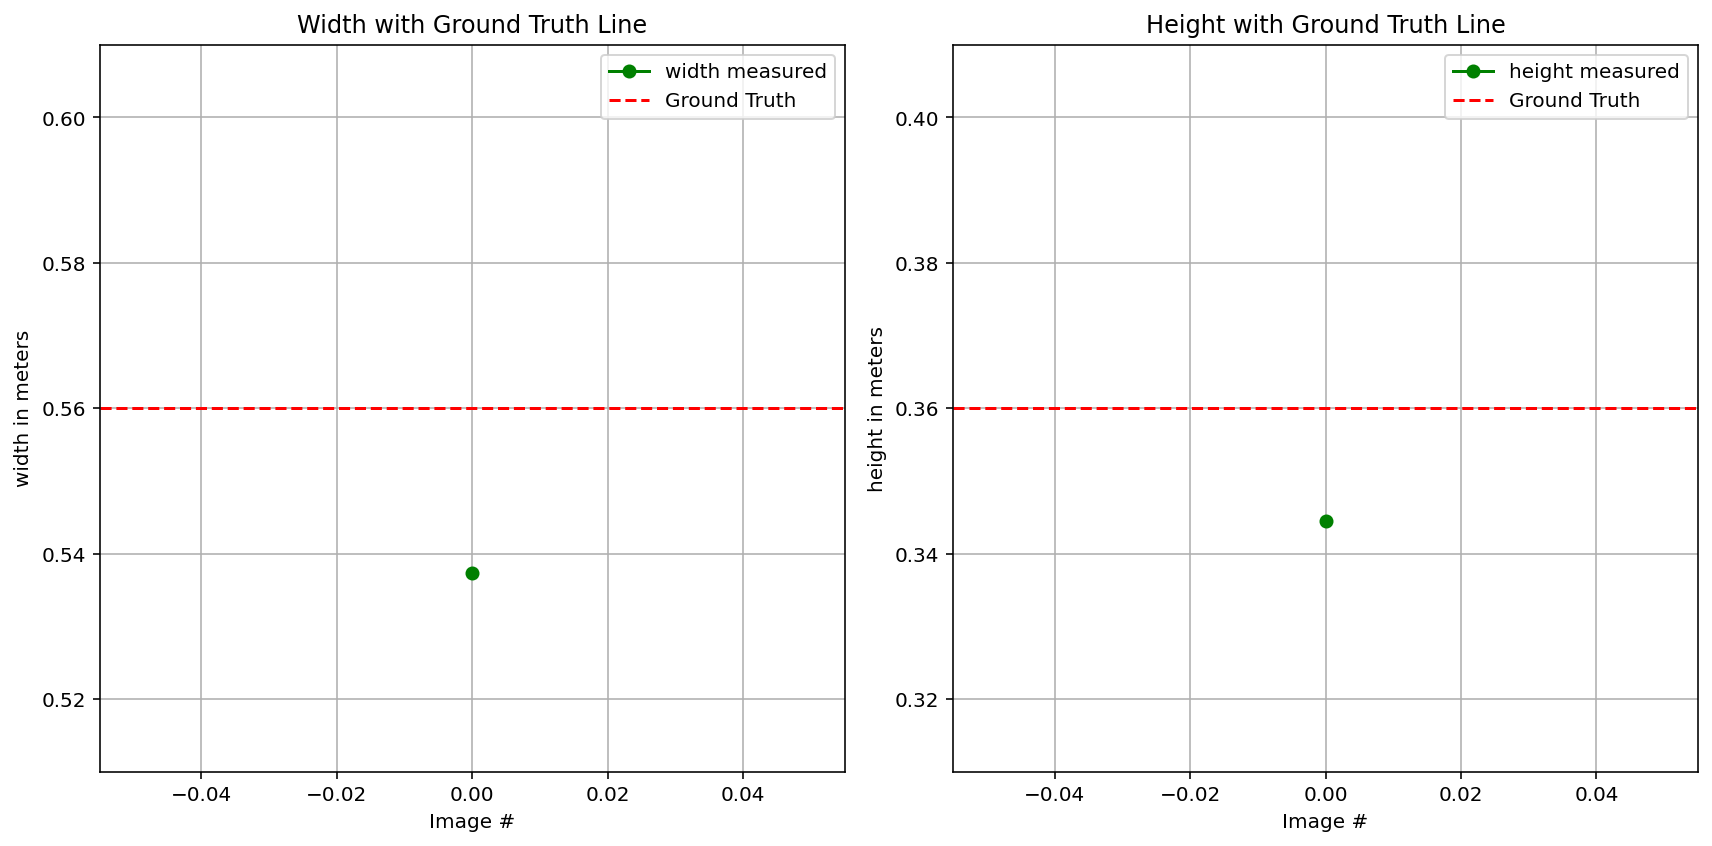

In [ ]:
# Compare the calculated hight with the ground-truth dimensions of the board
# measured with a ruler (Set the measured values at the top of this script)

if not CALIBRATION_IS_ACCURATE:
  # raise ValueError("The Calibration seems off and hence the calculated dimensions are not accurate.")
  print("[ERROR] The Calibration seems off and hence the calculated dimensions are not accurate.")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

x_coords = [point[0] for point in width_3d_list]
y_coords = [point[1] for point in width_3d_list]
axes[0].plot(x_coords, y_coords, label='width measured', color='green', marker='o')
# Add a horizontal line at the ground truth value
axes[0].axhline(y=CHARUCO_GROUND_TRUTH_WIDTH, color='red', linestyle='--', label='Ground Truth')
# Add labels and title
axes[0].set_xlabel('Image #')
axes[0].set_ylabel('width in meters')
axes[0].set_title('Width with Ground Truth Line')
axes[0].set_ylim(CHARUCO_GROUND_TRUTH_WIDTH - 0.05, CHARUCO_GROUND_TRUTH_WIDTH + 0.05)
# Add a legend
axes[0].legend()
axes[0].grid(True)

x_coords = [point[0] for point in height_3d_list]
y_coords = [point[1] for point in height_3d_list]
axes[1].plot(x_coords, y_coords, label='height measured', color='green', marker='o')
# Add a horizontal line at the ground truth value
axes[1].axhline(y=CHARUCO_GROUND_TRUTH_HEIGHT, color='red', linestyle='--', label='Ground Truth')
# Add labels and title
axes[1].set_xlabel('Image #')
axes[1].set_ylabel('height in meters')
axes[1].set_title('Height with Ground Truth Line')
axes[1].set_ylim(CHARUCO_GROUND_TRUTH_HEIGHT - 0.05, CHARUCO_GROUND_TRUTH_HEIGHT + 0.05)
# Add a legend
axes[1].legend()
axes[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate deviations
widths = [point[1] for point in width_3d_list if point[1] is not None]
heights = [point[1] for point in height_3d_list if point[1] is not None]

average_width_deviation = np.mean(np.abs(np.array(widths) - CHARUCO_GROUND_TRUTH_WIDTH))
average_height_deviation = np.mean(np.abs(np.array(heights) - CHARUCO_GROUND_TRUTH_HEIGHT))

width_standard_deviation = np.sqrt(np.mean((np.array(widths) - CHARUCO_GROUND_TRUTH_WIDTH)**2))
height_standard_deviation = np.sqrt(np.mean((np.array(heights) - CHARUCO_GROUND_TRUTH_HEIGHT)**2))
print(f"The average width deviation is \033[1m{average_width_deviation:.4f} m\033[0m (or \033[1m{average_width_deviation * 1000:.4f} mm\033[0m), with a standard deviation of \033[1m{width_standard_deviation:.4f} m\033[0m (or \033[1m{width_standard_deviation * 1000:.4f} mm\033[0m)")
print(f"The average height deviation is \033[1m{average_height_deviation:.4f} m\033[0m (or \033[1m{average_height_deviation * 1000:.4f} mm\033[0m), with a standard deviation of \033[1m{height_standard_deviation:.4f} m\033[0m (or \033[1m{height_standard_deviation * 1000:.4f} mm\033[0m)")

The average width deviation is 0.0227 m (or 22.6554 mm), with a standard deviation of 0.0227 m (or 22.6554 mm)
The average height deviation is 0.0155 m (or 15.4933 mm), with a standard deviation of 0.0155 m (or 15.4933 mm)


## 12. Draw the Detected Markers on the Image

[INFO] The width ratio between Original to Projected is: 1:0.9595.
[INFO] The height ratio between Original to Projected is: 1:0.9570.



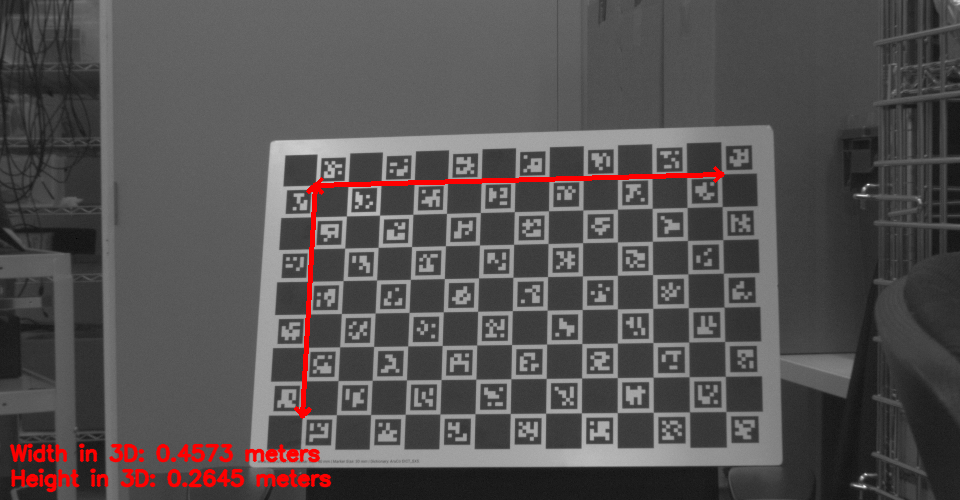

In [ ]:
# Chose the sample-image to show the calculated physical dimentions of the board
if FINAL_OVERLAY_IMAGE == 'auto':
  overlay_img_to_display = common_image_nr_with_complete_row_and_col[0]
else:
  overlay_img_to_display = FINAL_OVERLAY_IMAGE

img_left = cv2.imread(image_left_paths[overlay_img_to_display])
img_right = cv2.imread(image_right_paths[overlay_img_to_display])

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
color = (0, 0, 255)
thickness = 2

try:
  x_start = int(horizontal_end_points_per_img[overlay_img_to_display][0][0])
  y_start = int(horizontal_end_points_per_img[overlay_img_to_display][0][1])
  x_end = int(horizontal_end_points_per_img[overlay_img_to_display][1][0])
  y_end = int(horizontal_end_points_per_img[overlay_img_to_display][1][1])
  # Draw red dots at the projected points
  cv2.circle(img_left, (x_start, y_start), radius=3, color=(0, 0, 255), thickness=-1)
  cv2.circle(img_left, (x_end, y_end), radius=3, color=(0, 0, 255), thickness=-1)

  # Draw a red line connecting the two points
  cv2.arrowedLine(img_left, (x_start, y_start), (x_end, y_end), (0, 0, 255), 3, tipLength=0.02)
  cv2.arrowedLine(img_left, (x_end, y_end), (x_start, y_start), (0, 0, 255), 3, tipLength=0.02)
  # text_position_width = (x_start, y_start - 40)
  text_position_width = (10, image_height - 40)
  width_for_arrow = width_3d_img_dict[overlay_img_to_display] - 2 * one_square_side
  width_text = f"Width in 3D: {width_for_arrow:.4f} meters"
  cv2.putText(img_left, width_text, text_position_width, font, font_scale, color, thickness, cv2.LINE_AA)
  projected_width_ratio = width_3d_img_dict[overlay_img_to_display] / CHARUCO_GROUND_TRUTH_WIDTH
  print(f"[INFO] The width ratio between Original to Projected is: \033[1m1:{projected_width_ratio:.4f}\033[0m.")

  x_start = int(vertical_end_points_per_img[overlay_img_to_display][0][0])
  y_start = int(vertical_end_points_per_img[overlay_img_to_display][0][1])
  x_end = int(vertical_end_points_per_img[overlay_img_to_display][1][0])
  y_end = int(vertical_end_points_per_img[overlay_img_to_display][1][1])
  # Draw red dots at the projected points
  cv2.circle(img_left, (x_start, y_start), radius=3, color=(0, 0, 255), thickness=-1)
  cv2.circle(img_left, (x_end, y_end), radius=3, color=(0, 0, 255), thickness=-1)

  # Draw a red line connecting the two points
  cv2.arrowedLine(img_left, (x_start, y_start), (x_end, y_end), (0, 0, 255), 3, tipLength=0.04)
  cv2.arrowedLine(img_left, (x_end, y_end), (x_start, y_start), (0, 0, 255), 3, tipLength=0.04)
  # text_position_height = (x_start, y_start - 10)
  text_position_height = (10, image_height - 15)
  height_for_arrow = height_3d_img_dict[overlay_img_to_display] - 2 * one_square_side
  height_text = f"Height in 3D: {height_for_arrow:.4f} meters"
  cv2.putText(img_left, height_text, text_position_height, font, font_scale, color, thickness, cv2.LINE_AA)
  projected_height_ratio = height_3d_img_dict[overlay_img_to_display] / CHARUCO_GROUND_TRUTH_HEIGHT
  print(f"[INFO] The height ratio between Original to Projected is: \033[1m1:{projected_height_ratio:.4f}\033[0m.\n")
  # Display the image
  cv2_imshow(img_left)
except:
  print("[ERROR] Seems in width and/or in height the ends of the image cannot be seen in this image.")